In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

import math
from data_block import *

In [3]:
#export
class Dataset():
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __repr__(self, t=''):
        return f'{t}(Dataset) x: {tuple(self.x_data.shape)}, y: {tuple(self.y_data.shape)}'
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

In [4]:
#export
class Sampler():
    def __init__(self, size, batch_size, shuffle):
        self.size = size
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.size) if self.shuffle else torch.arange(self.size)
        for i in range(0, self.size, self.batch_size):
            yield self.idxs[i: i+self.batch_size]
    
    def __repr__(self, t=''):
        return f'{t}(Sampler) total: {self.size}, batch_size: {self.batch_size}, shuffle: {self.shuffle}'
        
    def __len__(self):
        return self.batch_size
            
def collate(batch):
    x_batch, y_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(y_batch)

In [5]:
#export
class DataLoader():
    def __init__(self, dataset, sampler, collate_fn=collate):
        self.dataset = dataset
        self.sampler = sampler
        self.collate_fn = collate_fn
        
    def __iter__(self):
        for idxs in self.sampler:
            yield self.collate_fn([self.dataset[i] for i in idxs])
    
    def __repr__(self, t=''):
        tt = t + '    '
        return f'{t}(DataLoader) \n{self.dataset.__repr__(tt)}\n{self.sampler.__repr__(tt)}'
        
    def __len__(self):
        return math.ceil(len(self.dataset) / len(self.sampler))

class DataBunch():
    def __init__(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset
    
    def __repr__(self, t=''):
        tt = t + '    '
        return f'{t}(DataBunch) \n{self.train_dl.__repr__(tt)}\n{self.valid_dl.__repr__(tt)}'
        
    def __len__(self):
        return len(self.train_dl)

In [6]:
x_train, y_train, x_valid, y_valid = get_mnist_data()
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)
print(train_ds)
print(valid_ds)

(Dataset) x: (50000, 784), y: (50000,)
(Dataset) x: (10000, 784), y: (10000,)


In [7]:
train_sampler = Sampler(len(train_ds), 64, True)
valid_sampler = Sampler(len(valid_ds), 64*2, False)
print(train_sampler)
print(valid_sampler)

(Sampler) total: 50000, batch_size: 64, shuffle: True
(Sampler) total: 10000, batch_size: 128, shuffle: False


In [8]:
train_dl = DataLoader(train_ds, train_sampler)
valid_dl = DataLoader(valid_ds, valid_sampler)
print(train_dl)
print(valid_dl)

(DataLoader) 
    (Dataset) x: (50000, 784), y: (50000,)
    (Sampler) total: 50000, batch_size: 64, shuffle: True
(DataLoader) 
    (Dataset) x: (10000, 784), y: (10000,)
    (Sampler) total: 10000, batch_size: 128, shuffle: False


In [9]:
data_bunch = DataBunch(train_dl, valid_dl)
print(data_bunch)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False


In [10]:
#export
def get_data_bunch(x_train, y_train, x_valid, y_valid, batch_size):
    train_ds = Dataset(x_train, y_train)
    valid_ds = Dataset(x_valid, y_valid)
    train_dl = DataLoader(train_ds, Sampler(len(train_ds), batch_size, True))
    valid_dl = DataLoader(valid_ds, Sampler(len(valid_ds), batch_size*2, False)) # twice batch size (no backprop)
    return DataBunch(train_dl, valid_dl)

In [11]:
data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
data_bunch

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False

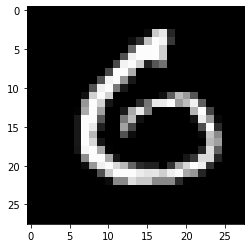

In [12]:
# rerun for random sampled image
x_batch, _ = next(iter(data_bunch.train_dl))
show_random_image(x_batch)